# Settings

In [1]:
%load_ext autoreload
%autoreload 2
%autoreload

In [1]:
# add parent_path to path for imports
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
if not os.getcwd().endswith("kit_d-fine_sports-analytics"):
    os.chdir("..")


In [3]:
import matplotlib
import src
from src import config
from src.models import ball_gain_prediction
from src.utils import db_handler, utils
from src.models.ball_gain_prediction import *
import sklearn
import shap
target_set = "target_dataset_shift_2sec_hypothesis_testing"
df_target = db_handler.get_table(target_set)

Here the optimized parameters are used. As agreed, due to the extremely high correlation between lanes/thirds and centroids, the centroids were already removed here (due to the worse interpretability).

In [4]:
key_columns = ["match_id", "half", "frame", "target"]
hypo_columns = ["lane_right", "lane_middle", "lane_left",
                "third_attacking", "third_middle","third_defending",
                "attacking_team_is_team_with_more_possession", "home_team_is_in_possession",
                "home_team_buli_bottom_6", "away_team_buli_top_6", "home_team_buli_top_6",
                "home_team_buli_middle_6",  "away_team_buli_middle_6", "away_team_buli_bottom_6"
]
all_columns = [col for col in df_target.columns if "centroid" not in col]
all_columns#

['defensive_pressure_shift_0_sec_1_attackers',
 'defensive_pressure_shift_1_sec_1_attackers',
 'defensive_pressure_shift_3_sec_1_attackers',
 'defensive_pressure_shift_5_sec_1_attackers',
 'defensive_pressure_average_1_sec_1_attackers',
 'defensive_pressure_difference_1_sec_1_attackers',
 'defensive_pressure_average_3_sec_1_attackers',
 'defensive_pressure_difference_3_sec_1_attackers',
 'defensive_pressure_average_5_sec_1_attackers',
 'defensive_pressure_difference_5_sec_1_attackers',
 'defensive_pressure_shift_0_sec_3_attackers',
 'defensive_pressure_shift_1_sec_3_attackers',
 'defensive_pressure_shift_3_sec_3_attackers',
 'defensive_pressure_shift_5_sec_3_attackers',
 'defensive_pressure_average_1_sec_3_attackers',
 'defensive_pressure_difference_1_sec_3_attackers',
 'defensive_pressure_average_3_sec_3_attackers',
 'defensive_pressure_difference_3_sec_3_attackers',
 'defensive_pressure_average_5_sec_3_attackers',
 'defensive_pressure_difference_5_sec_3_attackers',
 'defensive_pressu

# all-features-model

In [5]:
# the params were optimized by hyperparameter finder
# these params proved to be efficient on all datasets (which are very similar) and are not changed for consistency
corr_threshold = 1
use_f_score=True
classifier = "RandomForest"
inv_training_test=True
use_stored_k_best = False
params = {'max_features': 'sqrt', 
          'max_depth': 20, 
          'min_samples_split': 10, 
          'min_samples_leaf': 10, 
          'class_weight': 'balanced', 
          'n_estimators': 250, 
          'bootstrap': False}
target_data_columns =  all_columns
df_target = df_target[all_columns]
print(f"number cols is {len(all_columns)}")


number cols is 338


Predicting with RandomForest and params {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'n_estimators': 250, 'bootstrap': False}
Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003

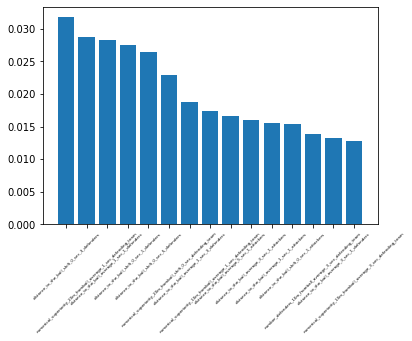

distance_to_the_ball_shift_0_sec_3_defenders                       0.031767
numerical_superiority_20m_fromball_average_1_sec_defending_team    0.028723
distance_to_the_ball_average_1_sec_1_defenders                     0.028361
distance_to_the_ball_shift_0_sec_1_defenders                       0.027533
distance_to_the_ball_shift_0_sec_5_defenders                       0.026439
numerical_superiority_20m_fromball_shift_0_sec_defending_team      0.022992
distance_to_the_ball_average_1_sec_3_defenders                     0.018858
numerical_superiority_10m_fromball_average_1_sec_defending_team    0.017389
distance_to_the_ball_average_5_sec_1_attackers                     0.016681
distance_to_the_ball_average_3_sec_1_attackers                     0.016088
distance_to_the_ball_average_1_sec_1_attackers                     0.015593
distance_to_the_ball_shift_0_sec_1_attackers                       0.015336
number_defenders_10m_fromball_average_3_sec_defending_team         0.013895
distance_to_

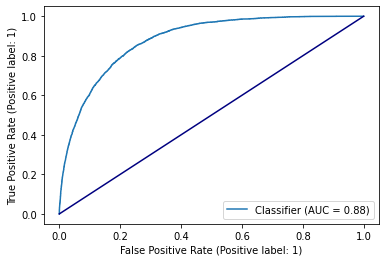

[[20727  2665]
 [ 1612  2944]]


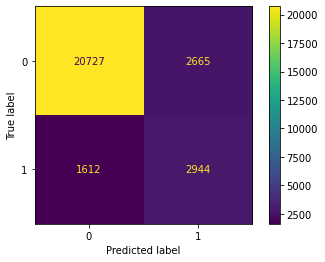

In [23]:
feat_imp_all, clf_all = ball_gain_prediction.main(clf=classifier, use_k_best_features = use_stored_k_best, corr_threshold = corr_threshold, params = params,
    name_target_set = target_set, target_data_columns = target_data_columns, evaluation_set = "test")

# minimal-time-model

In [43]:
no_time_info_cols = [col for col in all_columns if "mean" not in col and "difference" not in col 
                    and "shift_1" not in col and "shift_3" not in col and "shift_5" not in col and "average" not in col]
no_time_info_cols

['defensive_pressure_shift_0_sec_1_attackers',
 'defensive_pressure_shift_0_sec_3_attackers',
 'defensive_pressure_shift_0_sec_5_attackers',
 'dis_def_att_defending_team_shift_0_sec_defending_team',
 'dis_def_mid_defending_team_shift_0_sec_defending_team',
 'dis_mid_att_defending_team_shift_0_sec_defending_team',
 'distance_to_the_ball_shift_0_sec_1_attackers',
 'distance_to_the_ball_shift_0_sec_3_attackers',
 'distance_to_the_ball_shift_0_sec_5_attackers',
 'distance_to_the_ball_shift_0_sec_1_defenders',
 'distance_to_the_ball_shift_0_sec_3_defenders',
 'distance_to_the_ball_shift_0_sec_5_defenders',
 'number_defenders_10m_fromball_shift_0_sec_defending_team',
 'number_defenders_15m_lastdefender_shift_0_sec_defending_team',
 'number_defenders_20m_fromball_shift_0_sec_defending_team',
 'number_defenders_own_final_third_shift_0_sec_defending_team',
 'number_defenders_own_half_shift_0_sec_defending_team',
 'numerical_superiority_10m_fromball_shift_0_sec_defending_team',
 'numerical_super

In [44]:
len(no_time_info_cols)

50

Predicting with RandomForest and params {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'n_estimators': 250, 'bootstrap': False}
Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003

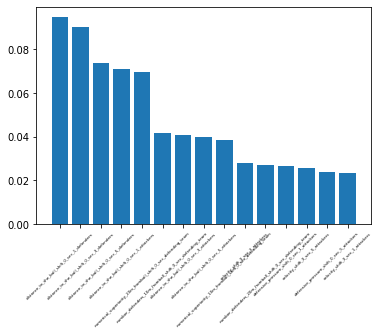

distance_to_the_ball_shift_0_sec_1_defenders                     0.094857
distance_to_the_ball_shift_0_sec_3_defenders                     0.090186
distance_to_the_ball_shift_0_sec_5_defenders                     0.073723
distance_to_the_ball_shift_0_sec_1_attackers                     0.071151
numerical_superiority_20m_fromball_shift_0_sec_defending_team    0.069487
number_defenders_10m_fromball_shift_0_sec_defending_team         0.041825
distance_to_the_ball_shift_0_sec_3_attackers                     0.040788
distance_to_the_ball_shift_0_sec_5_attackers                     0.039953
numerical_superiority_10m_fromball_shift_0_sec_defending_team    0.038500
velocity_shift_0_sec_3_attackers                                 0.027925
number_defenders_20m_fromball_shift_0_sec_defending_team         0.026965
defensive_pressure_shift_0_sec_1_attackers                       0.026512
velocity_shift_0_sec_5_attackers                                 0.025816
defensive_pressure_shift_0_sec_5_attac

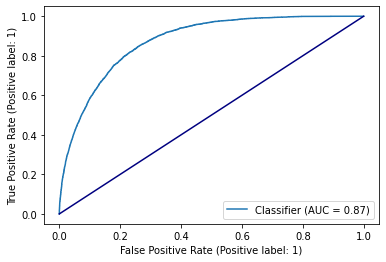

[[19702  3690]
 [ 1330  3226]]


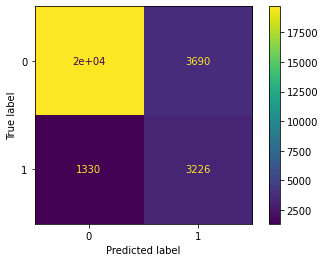

In [45]:
feat_imp_no_time, clf_no_time = ball_gain_prediction.main(clf=classifier, use_k_best_features = use_stored_k_best, corr_threshold = corr_threshold, params = params,
    name_target_set = target_set, target_data_columns = no_time_info_cols, evaluation_set = "test")

# minimal-player-model

In [27]:
no_spatial_info_cols = [col for col in all_columns if "5_def" not in col and "3_def" not in col 
                        and "3_att" not in col and "5_att" not in col]
no_spatial_info_cols

['defensive_pressure_shift_0_sec_1_attackers',
 'defensive_pressure_shift_1_sec_1_attackers',
 'defensive_pressure_shift_3_sec_1_attackers',
 'defensive_pressure_shift_5_sec_1_attackers',
 'defensive_pressure_average_1_sec_1_attackers',
 'defensive_pressure_difference_1_sec_1_attackers',
 'defensive_pressure_average_3_sec_1_attackers',
 'defensive_pressure_difference_3_sec_1_attackers',
 'defensive_pressure_average_5_sec_1_attackers',
 'defensive_pressure_difference_5_sec_1_attackers',
 'dis_def_att_defending_team_shift_0_sec_defending_team',
 'dis_def_att_defending_team_shift_1_sec_defending_team',
 'dis_def_att_defending_team_shift_3_sec_defending_team',
 'dis_def_att_defending_team_shift_5_sec_defending_team',
 'dis_def_att_defending_team_average_1_sec_defending_team',
 'dis_def_att_defending_team_difference_1_sec_defending_team',
 'dis_def_att_defending_team_average_3_sec_defending_team',
 'dis_def_att_defending_team_difference_3_sec_defending_team',
 'dis_def_att_defending_team_av

In [28]:
len(no_spatial_info_cols)

238

Predicting with RandomForest and params {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'n_estimators': 250, 'bootstrap': False}
Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003

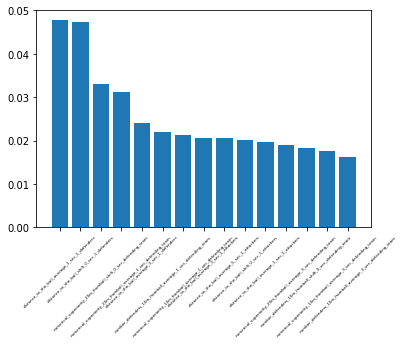

distance_to_the_ball_average_1_sec_1_defenders                     0.047701
distance_to_the_ball_shift_0_sec_1_defenders                       0.047244
numerical_superiority_20m_fromball_shift_0_sec_defending_team      0.033078
numerical_superiority_20m_fromball_average_1_sec_defending_team    0.031198
distance_to_the_ball_average_3_sec_1_defenders                     0.024134
number_defenders_10m_fromball_average_1_sec_defending_team         0.021968
numerical_superiority_10m_fromball_average_1_sec_defending_team    0.021240
distance_to_the_ball_average_3_sec_1_attackers                     0.020640
distance_to_the_ball_average_5_sec_1_attackers                     0.020589
distance_to_the_ball_shift_0_sec_1_attackers                       0.020211
distance_to_the_ball_average_1_sec_1_attackers                     0.019569
numerical_superiority_20m_fromball_average_3_sec_defending_team    0.018973
number_defenders_10m_fromball_shift_0_sec_defending_team           0.018370
numerical_su

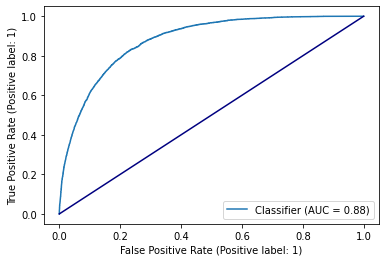

[[20645  2747]
 [ 1585  2971]]


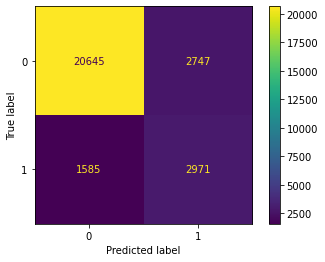

In [29]:
feat_imp_no_spatial, clf_no_spatial = ball_gain_prediction.main(clf=classifier, use_k_best_features = use_stored_k_best, corr_threshold = corr_threshold, params = params,
    name_target_set = target_set, target_data_columns = no_spatial_info_cols, evaluation_set = "test")

# minimal-model

In [54]:
minimal_cols = [col for col in no_spatial_info_cols if col in no_time_info_cols]
minimal_cols

['defensive_pressure_shift_0_sec_1_attackers',
 'dis_def_att_defending_team_shift_0_sec_defending_team',
 'dis_def_mid_defending_team_shift_0_sec_defending_team',
 'dis_mid_att_defending_team_shift_0_sec_defending_team',
 'distance_to_the_ball_shift_0_sec_1_attackers',
 'distance_to_the_ball_shift_0_sec_1_defenders',
 'number_defenders_10m_fromball_shift_0_sec_defending_team',
 'number_defenders_15m_lastdefender_shift_0_sec_defending_team',
 'number_defenders_20m_fromball_shift_0_sec_defending_team',
 'number_defenders_own_final_third_shift_0_sec_defending_team',
 'number_defenders_own_half_shift_0_sec_defending_team',
 'numerical_superiority_10m_fromball_shift_0_sec_defending_team',
 'numerical_superiority_15m_lastdefender_shift_0_sec_defending_te',
 'numerical_superiority_20m_fromball_shift_0_sec_defending_team',
 'numerical_superiority_own_final_third_shift_0_sec_defending_tea',
 'numerical_superiority_own_half_shift_0_sec_defending_team',
 'spread_team_shift_0_sec_attacking_team',


In [87]:
len(minimal_cols)

40

Predicting with RandomForest and params {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'n_estimators': 250, 'bootstrap': False}
Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003

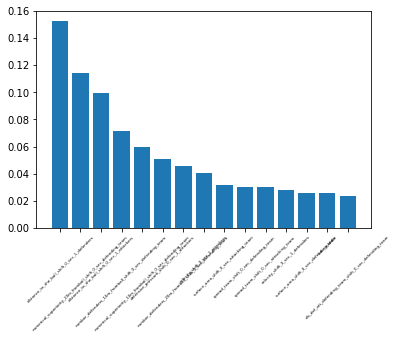

distance_to_the_ball_shift_0_sec_1_defenders                     0.152658
numerical_superiority_20m_fromball_shift_0_sec_defending_team    0.114311
distance_to_the_ball_shift_0_sec_1_attackers                     0.099262
number_defenders_10m_fromball_shift_0_sec_defending_team         0.071160
numerical_superiority_10m_fromball_shift_0_sec_defending_team    0.059655
defensive_pressure_shift_0_sec_1_attackers                       0.050979
number_defenders_20m_fromball_shift_0_sec_defending_team         0.045838
velocity_shift_0_sec_1_attackers                                 0.040206
surface_area_shift_0_sec_attacking_team                          0.031396
spread_team_shift_0_sec_defending_team                           0.030143
spread_team_shift_0_sec_attacking_team                           0.030085
velocity_shift_0_sec_1_defenders                                 0.028110
surface_area_shift_0_sec_defending_team                          0.025801
lane_middle                           

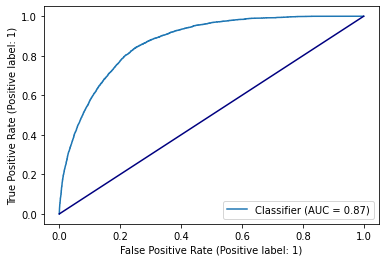

[[19549  3843]
 [ 1314  3242]]


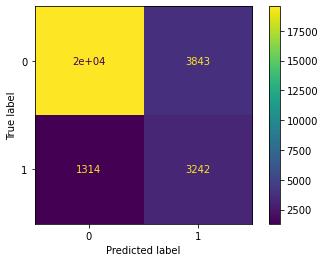

In [56]:
feat_imp_minimal, clf_minimal = ball_gain_prediction.main(clf=classifier, use_k_best_features = use_stored_k_best, corr_threshold = corr_threshold, params = params,
    name_target_set = target_set, target_data_columns = minimal_cols, evaluation_set = "test")

In [89]:
import src
from src import config
from src.models import ball_gain_prediction
from src.utils import db_handler, utils
import sklearn
import pandas as pd
import shap
from shap import TreeExplainer

In [88]:
data_dict = ball_gain_prediction.split_train_test_validation(df_target[minimal_cols])

Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003C5V, 003C5W, 003C5Y, 003C5Z, 003C60, 003C61, 003C62, 003C63, 003C64, 003C65, 003C66
Test matches are: 003C1Z, 003C21, 003C22, 003C23, 003C24, 003C25, 003C26, 003C27, 003C28, 003C29, 003C2A, 003C2B, 00

In [91]:
explainer = shap.Explainer(clf_minimal.predict, data_dict["x_test"].values)

In [92]:
shap_values = explainer(data_dict["x_test"].values)

Permutation explainer: 27949it [14:53:13,  1.92s/it]                                                                   


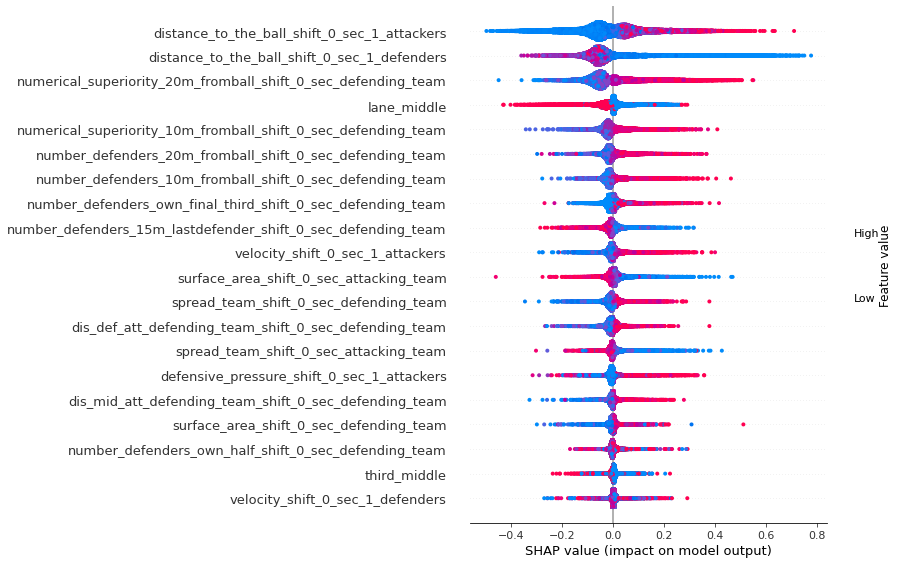

In [93]:
shap.summary_plot(shap_values,data_dict["x_test"])

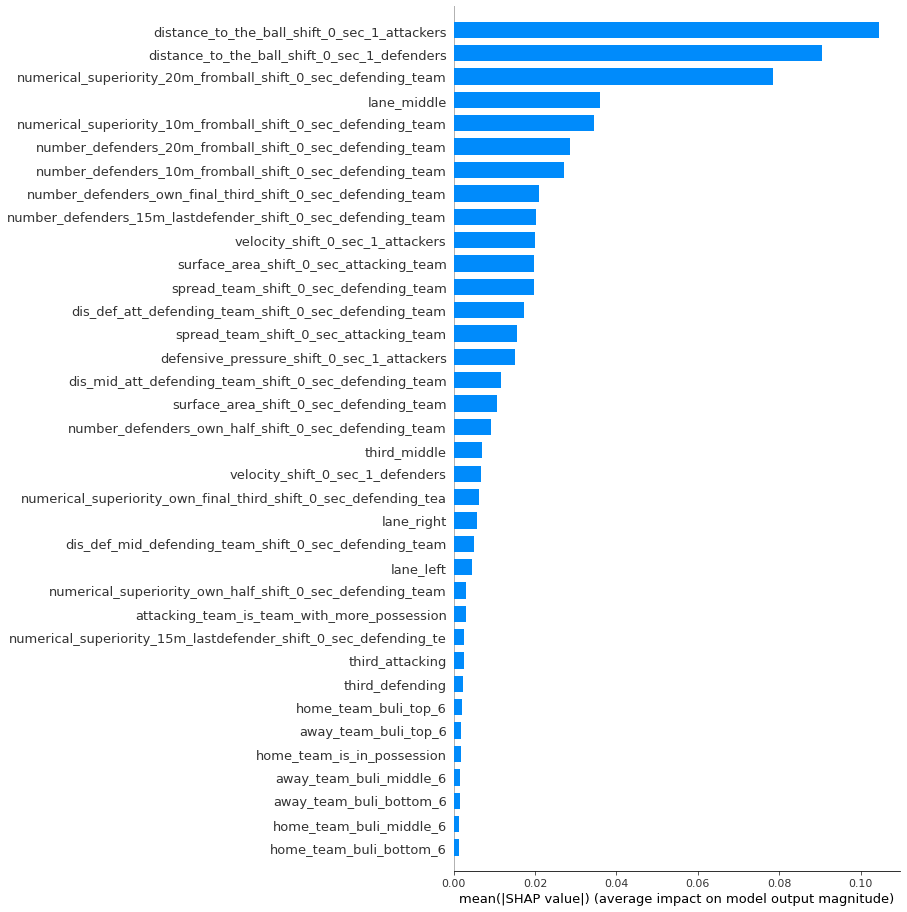

In [94]:
shap.summary_plot(shap_values,data_dict["x_test"], plot_type="bar", max_display= 50)

# expert-model

minimal cols + 3 seconds average für distance_to_the_ball

In [97]:
min_plus_distance_ball_red = [col for col in no_spatial_info_cols if 
                         ("difference" not in col and "average" not in col
                          and "shift_3" not in col and "shift_5" not in col and "shift_1" not in col)
                        or ("distance_to_the_ball" in col and "average_3"  in col)]
print(len(min_plus_distance_ball_red))
min_plus_distance_ball_red

42


['defensive_pressure_shift_0_sec_1_attackers',
 'dis_def_att_defending_team_shift_0_sec_defending_team',
 'dis_def_mid_defending_team_shift_0_sec_defending_team',
 'dis_mid_att_defending_team_shift_0_sec_defending_team',
 'distance_to_the_ball_shift_0_sec_1_attackers',
 'distance_to_the_ball_average_3_sec_1_attackers',
 'distance_to_the_ball_shift_0_sec_1_defenders',
 'distance_to_the_ball_average_3_sec_1_defenders',
 'number_defenders_10m_fromball_shift_0_sec_defending_team',
 'number_defenders_15m_lastdefender_shift_0_sec_defending_team',
 'number_defenders_20m_fromball_shift_0_sec_defending_team',
 'number_defenders_own_final_third_shift_0_sec_defending_team',
 'number_defenders_own_half_shift_0_sec_defending_team',
 'numerical_superiority_10m_fromball_shift_0_sec_defending_team',
 'numerical_superiority_15m_lastdefender_shift_0_sec_defending_te',
 'numerical_superiority_20m_fromball_shift_0_sec_defending_team',
 'numerical_superiority_own_final_third_shift_0_sec_defending_tea',
 'n

Predicting with RandomForest and params {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'n_estimators': 250, 'bootstrap': False}
Training matches are: 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A, 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S
Validation matches are: 003C5T, 003C5U, 003C5V, 003C5W, 003C5Y, 003C5Z, 003C60, 003C61, 003C62, 003C63, 003C64, 003C65, 003C66, 003C1Z, 003C21, 003

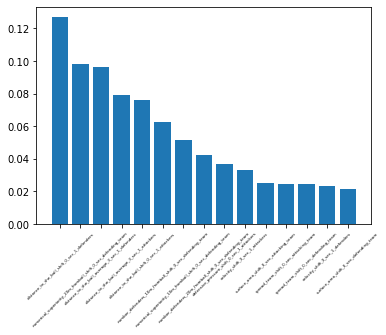

distance_to_the_ball_shift_0_sec_1_defenders                     0.127059
numerical_superiority_20m_fromball_shift_0_sec_defending_team    0.098407
distance_to_the_ball_average_3_sec_1_defenders                   0.096302
distance_to_the_ball_average_3_sec_1_attackers                   0.079117
distance_to_the_ball_shift_0_sec_1_attackers                     0.075998
number_defenders_10m_fromball_shift_0_sec_defending_team         0.062495
numerical_superiority_10m_fromball_shift_0_sec_defending_team    0.051251
number_defenders_20m_fromball_shift_0_sec_defending_team         0.042339
defensive_pressure_shift_0_sec_1_attackers                       0.037016
velocity_shift_0_sec_1_attackers                                 0.033041
surface_area_shift_0_sec_attacking_team                          0.024924
spread_team_shift_0_sec_attacking_team                           0.024674
spread_team_shift_0_sec_defending_team                           0.024551
velocity_shift_0_sec_1_defenders      

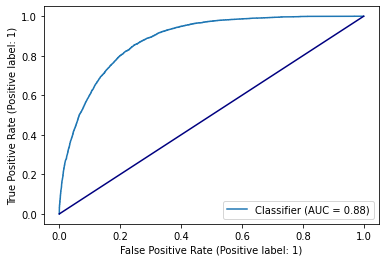

[[20369  3500]
 [ 1320  3251]]


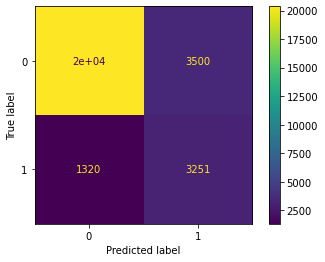

In [98]:
feat_imp_min_plus_dist_red, clf_min_plus_dist_red = ball_gain_prediction.main(clf=classifier, use_k_best_features = use_stored_k_best, corr_threshold = corr_threshold, params = params,
    name_target_set = target_set, target_data_columns = min_plus_distance_ball_red, evaluation_set = "test")

# expert-reduction-model (final model) 

In [8]:
features_final = [
    'match_id',
    'half',
    'frame',
    'target',
    'distance_to_the_ball_shift_0_sec_1_attackers',
    'distance_to_the_ball_shift_0_sec_1_defenders',
    "lane_middle",
    'numerical_superiority_20m_fromball_shift_0_sec_defending_team',
    'numerical_superiority_10m_fromball_shift_0_sec_defending_team',
    'number_defenders_20m_fromball_shift_0_sec_defending_team',
    'number_defenders_10m_fromball_shift_0_sec_defending_team',
    'number_defenders_own_final_third_shift_0_sec_defending_team',
    'number_defenders_15m_lastdefender_shift_0_sec_defending_team',
    'velocity_shift_0_sec_1_attackers',
    'surface_area_shift_0_sec_attacking_team',
    'spread_team_shift_0_sec_defending_team',
    'dis_def_att_defending_team_shift_0_sec_defending_team',
    'spread_team_shift_0_sec_attacking_team',
    'defensive_pressure_shift_0_sec_1_attackers',
    'distance_to_the_ball_average_3_sec_1_attackers',
    'distance_to_the_ball_average_3_sec_1_defenders']

20

Predicting with RandomForest and params {'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'n_estimators': 250, 'bootstrap': False}
Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003

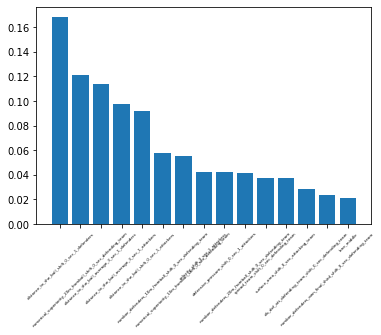

distance_to_the_ball_shift_0_sec_1_defenders                     0.168315
numerical_superiority_20m_fromball_shift_0_sec_defending_team    0.120755
distance_to_the_ball_average_3_sec_1_defenders                   0.113612
distance_to_the_ball_average_3_sec_1_attackers                   0.097342
distance_to_the_ball_shift_0_sec_1_attackers                     0.091825
number_defenders_10m_fromball_shift_0_sec_defending_team         0.057410
numerical_superiority_10m_fromball_shift_0_sec_defending_team    0.055337
velocity_shift_0_sec_1_attackers                                 0.042520
defensive_pressure_shift_0_sec_1_attackers                       0.042489
number_defenders_20m_fromball_shift_0_sec_defending_team         0.041106
spread_team_shift_0_sec_defending_team                           0.037636
surface_area_shift_0_sec_attacking_team                          0.037281
dis_def_att_defending_team_shift_0_sec_defending_team            0.028517
number_defenders_own_final_third_shift

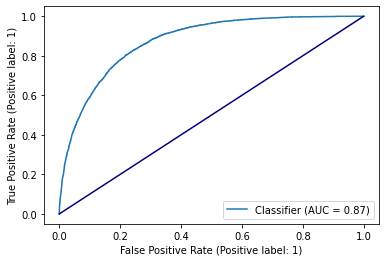

[[19830  3562]
 [ 1355  3201]]


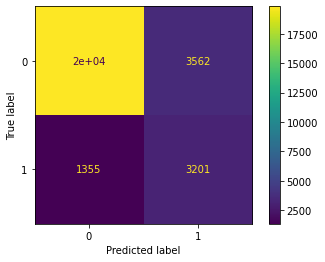

In [9]:
feat_imp_final, clf_final = ball_gain_prediction.main(clf=classifier, use_k_best_features = use_stored_k_best, corr_threshold = corr_threshold, params = params,
    name_target_set = target_set, target_data_columns = features_final, evaluation_set = "test")

# Explaining final model

In [16]:
data_dict_final_model_final = ball_gain_prediction.split_train_test_validation(df_target[features_final])

explainer_final_model_final = shap.Explainer(clf_final.predict, data_dict_final_model_final["x_test"].values)

Training matches are: 003C2T, 003C2U, 003C2V, 003C2W, 003C2X, 003C2Y, 003C2Z, 003C30, 003C31, 003C32, 003C33, 003C34, 003C35, 003C36, 003C37, 003C38, 003C3A, 003C3D, 003C3E, 003C3F, 003C3G, 003C3H, 003C3I, 003C3K, 003C3M, 003C3N, 003C3O, 003C3P, 003C3R, 003C3S, 003C3T, 003C3U, 003C3V, 003C3W, 003C3X, 003C3Y, 003C40, 003C41, 003C42, 003C43, 003C44, 003C45, 003C46, 003C47, 003C48, 003C4A, 003C4B, 003C4C, 003C4D, 003C4E, 003C4F, 003C4G, 003C4H, 003C4I, 003C4J, 003C4L, 003C4M, 003C4N, 003C4O, 003C4P, 003C4Q, 003C4R, 003C4S, 003C4T, 003C4U, 003C4V, 003C4W, 003C4X, 003C4Y, 003C4Z, 003C50, 003C51, 003C52, 003C53, 003C54, 003C55, 003C57, 003C59, 003C5A
Validation matches are: 003C5C, 003C5D, 003C5F, 003C5G, 003C5I, 003C5J, 003C5K, 003C5L, 003C5M, 003C5N, 003C5Q, 003C5R, 003C5S, 003C5T, 003C5U, 003C5V, 003C5W, 003C5Y, 003C5Z, 003C60, 003C61, 003C62, 003C63, 003C64, 003C65, 003C66
Test matches are: 003C1Z, 003C21, 003C22, 003C23, 003C24, 003C25, 003C26, 003C27, 003C28, 003C29, 003C2A, 003C2B, 00

In [17]:
shap_values_final_model_final = explainer_final_model_final(data_dict_final_model_final["x_test"].values)

Permutation explainer: 27949it [7:50:27,  1.01s/it]                                                                    


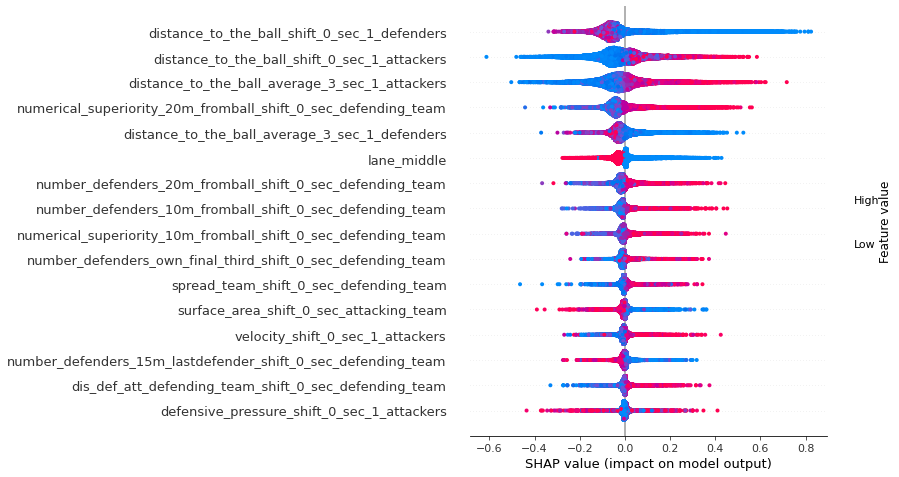

In [19]:
shap.summary_plot(shap_values_final_model_final,data_dict_final_model_final["x_test"])

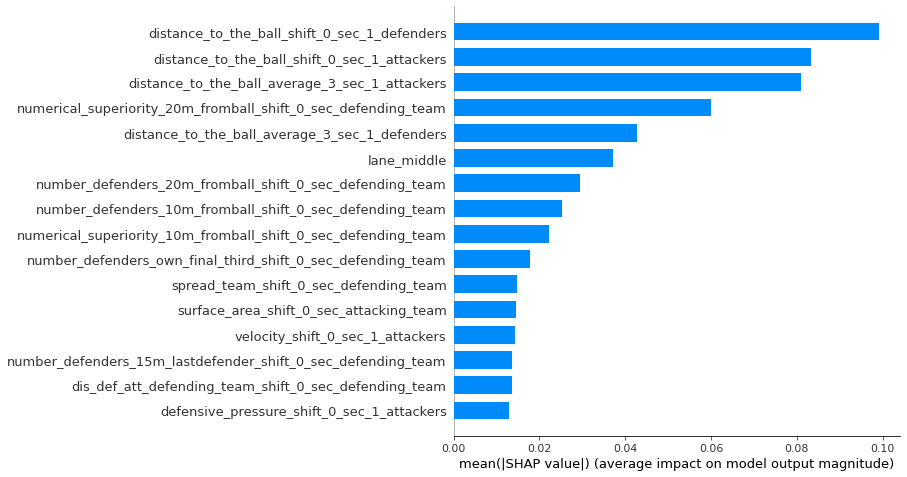

In [21]:
shap.summary_plot(shap_values_final_model_final,data_dict_final_model_final["x_test"], plot_type="bar", max_display= 50)

# rename variables for plots in the paper

In [23]:
data_dict_final_model_final["x_test"].columns = [col.replace("shift", "raw").replace("average", "mean") for col in data_dict_final_model_final["x_test"].columns]

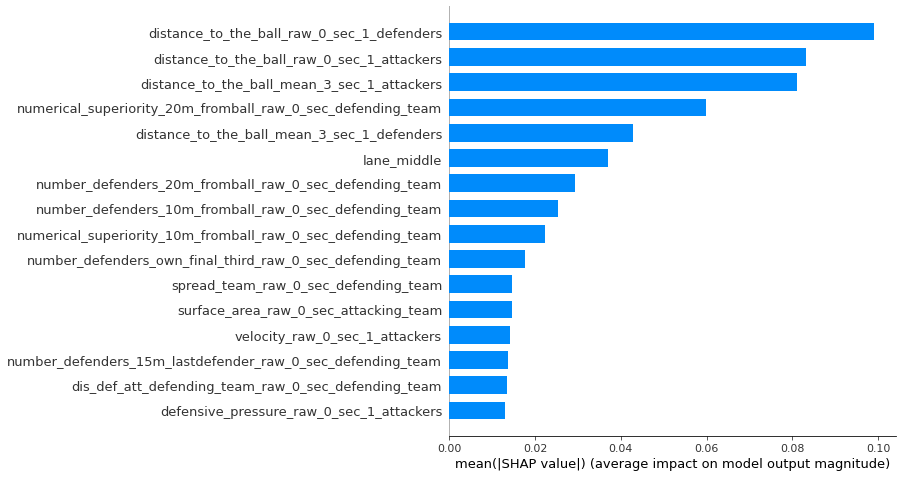

In [24]:
shap.summary_plot(shap_values_final_model_final,data_dict_final_model_final["x_test"], plot_type="bar", max_display= 50)

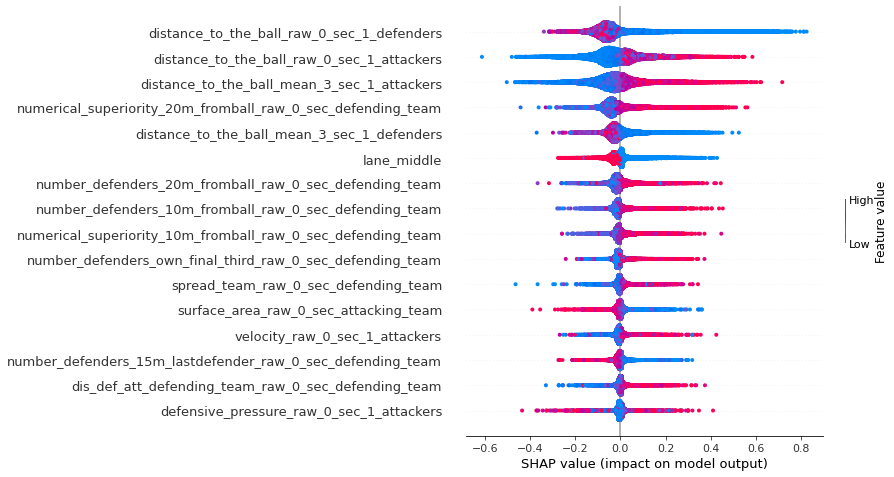

In [25]:
shap.summary_plot(shap_values_final_model_fina,data_dict_final_model_final["x_test"])

In [31]:
feat_imp_vals = np.abs(shap_values_final_model_final.values).mean(0).round(4)*100
feature_names = data_dict_final_model_final["x_test"].columns.tolist()
feature_importance = pd.DataFrame(list(zip(feature_names, feat_imp_vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True, ignore_index=True)
feature_importance

,col_name,feature_importance_vals
0,distance_to_the_ball_raw_0_sec_1_defenders,9.91
1,distance_to_the_ball_raw_0_sec_1_attackers,8.33
2,distance_to_the_ball_mean_3_sec_1_attackers,8.10
3,numerical_superiority_20m_fromball_raw_0_sec_d...,5.99
4,distance_to_the_ball_mean_3_sec_1_defenders,4.28
5,lane_middle,3.70
6,number_defenders_20m_fromball_raw_0_sec_defend...,2.94
7,number_defenders_10m_fromball_raw_0_sec_defend...,2.53
8,numerical_superiority_10m_fromball_raw_0_sec_d...,2.23
9,number_defenders_own_final_third_raw_0_sec_def...,1.78


In [32]:
features_final

['match_id',
 'half',
 'frame',
 'target',
 'distance_to_the_ball_shift_0_sec_1_attackers',
 'distance_to_the_ball_shift_0_sec_1_defenders',
 'lane_middle',
 'numerical_superiority_20m_fromball_shift_0_sec_defending_team',
 'numerical_superiority_10m_fromball_shift_0_sec_defending_team',
 'number_defenders_20m_fromball_shift_0_sec_defending_team',
 'number_defenders_10m_fromball_shift_0_sec_defending_team',
 'number_defenders_own_final_third_shift_0_sec_defending_team',
 'number_defenders_15m_lastdefender_shift_0_sec_defending_team',
 'velocity_shift_0_sec_1_attackers',
 'surface_area_shift_0_sec_attacking_team',
 'spread_team_shift_0_sec_defending_team',
 'dis_def_att_defending_team_shift_0_sec_defending_team',
 'defensive_pressure_shift_0_sec_1_attackers',
 'distance_to_the_ball_average_3_sec_1_attackers',
 'distance_to_the_ball_average_3_sec_1_defenders']